In [14]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
import random, math
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np

DEVICE = 'cpu'

In [24]:
letters = "0123456789+=! "
letter_to_idx = {l: ind for ind, l in enumerate(letters)}
PADDING_LETTER = ' '
STOP_LETTER = '!'

encode = lambda t: torch.tensor([letter_to_idx[a] for a in t])
decode = lambda t: ''.join([letters[a] for a in t])

In [16]:
class MathDataset(Dataset):
    
    def __init__(self, seed=49, max_num=1024, epoch_size=1000):
        self.max_num = max_num
        self.epoch_size = epoch_size
        self.seed = seed
        self.cache = [None for i in range(epoch_size)]

    def __len__(self):
        return self.epoch_size

    def __getitem__(self, idx):
        if self.cache[idx] is not None:
            return self.cache[idx]
        random.seed(self.seed + idx)
        num1 = random.randint(0, self.max_num)
        num2 = random.randint(0, self.max_num)
        op = '+'  # random.choice(['+', '-', '*', '/'])
        # print(f'{num1}{op}{num2}')
        eq = f'{num1}{op}{num2}' # with no = character
        res_eq = f'{eq}={eval(eq)}!'
        # len(res_eq) + 1 because of ! character at the end
        self.cache[idx] = encode(res_eq), torch.concat([torch.zeros(len(eq) + 1, dtype=torch.bool), torch.ones(len(res_eq) - (len(eq) + 1), dtype=torch.bool)])
        return self.cache[idx]
        
def collate(batch):
    eqs = pad_sequence([s[0] for s in batch], padding_value=letter_to_idx[PADDING_LETTER], batch_first=True)
    eqs_msk = pad_sequence([s[1] for s in batch], padding_value=False, batch_first=True)
    eqs_msk = F.pad(eqs_msk, (0, eqs.shape[-1] - eqs_msk.shape[-1]), mode='constant', value=0)
    return eqs, eqs_msk

dataset = MathDataset(epoch_size=2**15)
dataloader = DataLoader(dataset, batch_size=64, collate_fn=collate, shuffle=True, num_workers=2)
dataset_eval = MathDataset(epoch_size=2**10,seed=50)
dataloader_eval = DataLoader(dataset_eval, batch_size=1024, collate_fn=collate)

In [17]:
class MultiHeadAttn(nn.Module):
    
    def __init__(self, emb_dim, head_num, causal=False, dropout=0.1):
        assert emb_dim % head_num == 0
        super(MultiHeadAttn, self).__init__()
        self.emb_dim = emb_dim
        self.head_num = head_num
        self.ws = nn.Linear(emb_dim, emb_dim * 3)
        self.mask = None
        if causal:
            self.mask = torch.triu(
                torch.ones((100, 100), dtype=torch.bool, requires_grad=False),
                diagonal=1
            ).to(DEVICE)
        self.proj = nn.Linear(emb_dim, emb_dim)
        self.dropout = nn.Dropout(dropout)
        
    
    def forward(self, x):
        B, S, E = x.shape
        assert E == self.emb_dim
        
        ws = self.ws(x)
        ws = ws.view(B, S, 3, self.head_num, E // self.head_num)
        ws = ws.permute(2, 0, 3, 1, 4)
        kw, qw, vw = ws[0], ws[1], ws[2]
        attn_w = (kw @ qw.transpose(-1, -2)) / math.sqrt(kw.size(-1))
        if self.mask is not None:
            attn_w = attn_w.masked_fill_(self.mask[:S, :S], -torch.inf)
        attn = F.softmax(attn_w, dim=-1)
        res = attn @ vw
        res = res.permute(0, 2, 1, 3)
        res = res.reshape(B, S, E).contiguous()
        
        return self.dropout(self.proj(res))
        

class Block(nn.Module):
    
    def __init__(self, emb_dim, head_num, causal=False, dropout=0.1):
        super(Block, self).__init__()
        self.ln1 = nn.LayerNorm(emb_dim)
        self.ln2 = nn.LayerNorm(emb_dim)
        self.attn = MultiHeadAttn(emb_dim, head_num, causal)
        self.ff = nn.Sequential(
            nn.Linear(emb_dim, emb_dim * 4),
            nn.SiLU(),
            nn.Linear(emb_dim * 4, emb_dim),
            nn.Dropout(dropout)
        )
    
    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.ff(self.ln2(x))
        return x

class MathModel(nn.Module):
    
    def __init__(self, config):
        super(MathModel, self).__init__()
        self.pos_emb = nn.Embedding(config['max_context_size'], config['emb_dim'])
        self.emb = nn.Embedding(config['vocab_size'], config['emb_dim'])
        self.blocks = nn.ModuleList([
            Block(config['emb_dim'], config['head_num'], causal=True) for i in range(4)
        ])
        self.head = nn.Sequential(
            nn.Linear(config['emb_dim'], len(letters))
        )
    
    def forward(self, x):
        B, S = x.shape
        x = self.emb(x) + self.pos_emb(torch.arange(S, device=DEVICE).expand(B, S))
        for block in self.blocks:
            x = block(x)
        return self.head(x)

In [18]:
MODEL_CONFIG = {
    'vocab_size': len(letters),
    'emb_dim': 64,
    'head_num': 8,
    'max_context_size': 32
}

In [19]:
model = MathModel(MODEL_CONFIG).to(DEVICE)
opt = torch.optim.AdamW(model.parameters())
train_loss = []
eval_loss = []
eval_steps = []

In [20]:
def eval_model(model, loader):
    losses = []
    for x, xmsk in loader:
        model.eval()
        x = x.to(DEVICE)
        xmsk = xmsk.to(DEVICE)
        res = model(x)[:, :-1]
        targets = x[:, 1:]
        loss_mask = xmsk[:, 1:]
        loss = F.cross_entropy(res.reshape(-1, MODEL_CONFIG['vocab_size']), targets.reshape(-1), reduction='none')
        loss = (loss.view(loss_mask.shape) * loss_mask).sum() / loss_mask.sum()
        losses.append(loss.item())
    return np.mean(losses)

In [21]:
epochs = 25
pbar = tqdm(range(epochs))
for epoch in pbar:
    for x, xmsk in dataloader:
        x = x.to(DEVICE)
        xmsk = xmsk.to(DEVICE)
        model.train()
        res = model(x)[:, :-1]
        targets = x[:, 1:]
        loss_mask = xmsk[:, 1:]
        loss = F.cross_entropy(res.reshape(-1, MODEL_CONFIG['vocab_size']), targets.reshape(-1), reduction='none')
        loss = (loss.view(loss_mask.shape) * loss_mask).sum() / loss_mask.sum()

        train_loss.append(loss.item())
        pbar.set_description(f'loss: {np.round(np.mean(train_loss[-10:]), 3)} / eval: {np.round(eval_loss[-1], 3) if len(eval_loss) > 0 else "-"}')
        opt.zero_grad()
        loss.backward()
        opt.step()
    eval_steps.append(len(train_loss))
    eval_loss.append(eval_model(model, dataloader_eval))

loss: 0.034 / eval: 0.014: 100%|██████████| 25/25 [10:19<00:00, 24.77s/it]


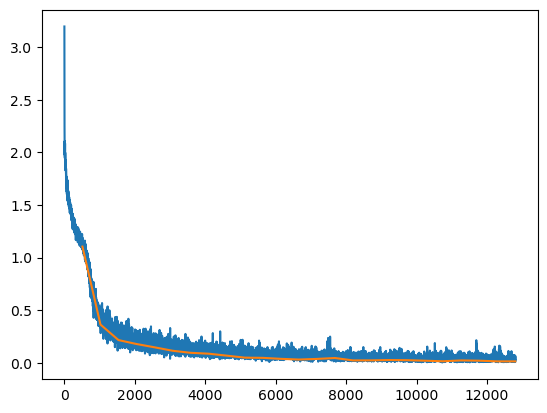

In [22]:
plt.plot(train_loss)
plt.plot(eval_steps, eval_loss)

In [38]:
def run_test(eq):
    model.eval()
    while True:
        x = encode(eq).view(1, -1)
        next_char = letters[model(x)[0, -1, :].argmax().item()]
        eq += next_char
        if next_char == '!':
            break
    return eq

In [62]:
print(run_test('102+158='))
print(run_test('298+123='))
print(run_test('1004+561=')) # kinda out of distribution
print(run_test('10004+1293=')) # out of distribution
print(run_test('9+2=')) # under represented group because of length
print(run_test('20+11='))

102+158=260!
298+123=421!
1004+561=1565!
10004+1293=1!
9+2=119!
20+11=31!
